## Download Data

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!ls -lha kaggle.json

In [ ]:
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/rsna-bone-age

In [ ]:
!unzip rsna-bone-age.zip

## Load Data

In [ ]:
from keras.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# File paths
train_path = '/content/boneage-training-dataset/boneage-training-dataset/'
val_path = '/content/drive/MyDrive/boneage_images/boneage-validation-dataset/'
test_path = '/content/boneage-test-dataset/boneage-test-dataset/'

In [ ]:
# Load dataframes
df_train, df_val, df_test = prep_dfs()
df_train_male, df_val_male, df_test_male, df_train_female, df_val_female, df_test_female = prep_sex_dfs()

In [ ]:
# Calculate mean & standard deviation of bone ages for data, including subsets
## All data
boneage_mean, boneage_std = boneage_mean_std(df_train, df_val)

## Male
male_boneage_mean, male_boneage_std = male_boneage_mean_std(df_train_male, df_val_male)

## Female
female_boneage_mean, female_boneage_std = female_boneage_mean_std(df_train_female, df_val_female)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


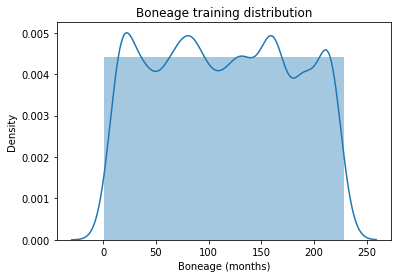

In [ ]:
# Group bone age into categories for resampling
df_train['boneage_category'] = pd.cut(df_train['boneage'], 10)
train_df = df_train.groupby(['boneage_category', 'gender2']).apply(lambda x: x.sample(500, replace=True)).reset_index(drop=True)
val_df = df_val

fig, ax = plt.subplots()
ax = sns.distplot(train_df['boneage'], bins=10)
ax.set(xlabel='Boneage (months)', ylabel='Density', title='Boneage training distribution');

### Image Preprocessing

In [ ]:
# Define parameters for images & models
pixels = 299
img_size = (pixels, pixels)
img_dims = (pixels, pixels, 3)
batch_size_train = 64
batch_size_val = 256
batch_size_test = len(df_test)
seed = 42
step_size_train = len(df_train) // batch_size_train
step_size_val = len(df_val) // batch_size_val(df_train) // batch_size_train
step_size_val = len(df_val) // batch_size_val

In [ ]:
# Instantiate generators
train_idg = idg(
    horizontal_flip = True,
    vertical_flip = False,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    rotation_range = 20,
    shear_range = 0.2,
    fill_mode = 'nearest',
    zoom_range = 0.2
    )

test_idg = idg()

# Generate inputs for images (single input, all data)
train_img_inputs = gen_img_inputs(train_idg, df_train, train_path, batch_size_train, True, img_size)
val_img_inputs = gen_img_inputs(test_idg, df_val, val_path, batch_size_val, False, img_size)
test_img_inputs = gen_img_inputs(test_idg, df_test, test_path, batch_size_test, False, img_size)

# Generate inputs for images (single input, sex-specific data)
male_train_img_inputs = gen_img_inputs(train_idg, df_train_male, train_path, batch_size_train, True, img_size)
male_val_img_inputs = gen_img_inputs(test_idg, df_val_male, val_path, batch_size_val, False, img_size)
male_test_img_inputs = gen_img_inputs(test_idg, df_test_male, test_path, batch_size_test, False, img_size)

female_train_img_inputs = gen_img_inputs(train_idg, df_train_female, train_path, batch_size_train, True, img_size)
female_val_img_inputs = gen_img_inputs(test_idg, df_val_female, val_path, batch_size_val, False, img_size)
female_test_img_inputs = gen_img_inputs(test_idg, df_test_female, test_path, batch_size_test, False, img_size)

# Generate inputs for images & sex variables (two inputs)
train_img_sex_inputs = gen_img_sex_inputs(train_idg, df_train, train_path, batch_size_train, True, img_size)
val_img_sex_inputs = gen_img_sex_inputs(test_idg, df_val, val_path, batch_size_val, False, img_size)
test_img_sex_inputs = gen_img_sex_inputs(test_idg, df_test, test_path, batch_size_test, False, img_size)

In [ ]:
# Calculate custom metrics
mae_months = mae_months(y_true, y_pred, boneage_mean, boneage_std)
mae_months_male = mae_months(y_true, y_pred, male_boneage_mean, male_boneage_std)
mae_months_female = mae_months(y_true, y_pred, female_boneage_mean, female_boneage_std)

# Analysis

In [ ]:
# Set up predictions
test_X, test_Y = next(test_img_sex_inputs)    # for image & sex inputs
test_X2, test_Y2 = next(test_img_inputs)    # for image input only
male_test_X, male_test_Y = next(male_test_img_inputs)
female_test_X, female_test_Y = next(female_test_img_inputs)

# Set up actual bone age values
test_Y_months = boneage_mean + boneage_std*test_Y
test_Y2_months = boneage_mean + boneage_std*test_Y2
male_test_Y_months = male_boneage_mean + male_boneage_std*male_test_Y
female_test_Y_months = female_boneage_mean + female_boneage_std*female_test_Y

Found 200 validated image filenames.
Found 200 validated image filenames.


In [ ]:
# Helper functions

# Load model
def get_model(model_path, metric_name, metric):
  return load_model(model_path, custom_objects={metric_name: metric})

# Evaluate model
def eval_model(model, test_X, test_Y):
  result = model.evaluate(test_X, test_Y)
  return dict(zip(model.metrics_names, result))

# Get predicted and actual bone ages in months
def preds(model, test_X, test_Y, mean_val, std_val, batch_size):
  pred_Y = mean_val + std_val*model.predict(test_X, batch_size=batch_size, verbose=True)
  return pred_Y

# Create predictions dataframe
def create_pred_df(df_test, pred_Y):
  preds = dict(zip(df_test['filename'], pred_Y))
  pred_df = pd.DataFrame.from_dict(preds, orient='index').reset_index()
  pred_df.rename(columns={'index': 'filename', 0: 'pred'}, inplace=True)
  pred_df = df_test.merge(pred_df)
  pred_df.drop(columns={'id'}, inplace=True)
  pred_df = pred_df[['filename', 'boneage', 'gender', 'pred', 'boneage_zscore']]
  pred_df['error'] = pred_df['boneage'] - pred_df['pred']
  pred_df['abs_error'] = abs(pred_df['error'])
  return pred_df

# Calculate mean & std dev of MAE for model
def error_mean_std(df):
  error_mean = df['abs_error'].mean()
  error_std = df['abs_error'].std()
  return error_mean, error_std

# Get outliers
def outliers(df):
  error_mean = df['abs_error'].mean()
  error_std = df['abs_error'].std()

  inaccurate = df[df['abs_error'] >= (error_mean + error_std)]
  accurate = df[df['abs_error'] <= (error_mean - error_std)]
  
  return inaccurate, accurate

def plot_outliers(inaccurate, accurate):
  # Plot gender distribution & boneage distrbution
  fig, ax = plt.subplots(2, 2)
  ax[0, 0].bar(inaccurate['gender']) #row=0, col=0
  ax[1, 0].plot(accurate['gender']) #row=1, col=0
  ax[0, 1].hist(inaccurate['boneage']) #row=0, col=1
  ax[1, 1].hist(accurate['boneage']) #row=1, col=1
  plt.show()

# Create residuals diagnostic plots
from scipy import stats

def res_plots(df):
  res = df['error']
  plt.figure(figsize=(15,6))
  
  # Residual plot
  plt.subplot(1, 2, 1)
  plt.scatter(df['pred'], res)
  # plt.axhline(0, color='r')
  plt.title('Residual plot')
  plt.xlabel('Predictions')
  plt.ylabel('Residuals')

  # Normal Q-Q plot
  plt.subplot(1, 2, 2)
  stats.probplot(res, dist='norm', plot=plt)
  plt.title('Normal Q-Q plot')
  plt.show()

def res_plots_gender(df):
  res = df['error']
  plt.figure(figsize=(8,6))
  
  # Residual plot
  sns.scatterplot(x='pred', y='error', data=df, hue='gender')
  plt.axhline(0, color='r')
  plt.title('Residual plot')
  plt.xlabel('Predictions')
  plt.ylabel('Residuals')
  plt.show()

# Plot predictions vs. actual
def plot_preds(df, model_name):
  plt.figure(figsize=(6,6))
  sns.scatterplot(x='boneage', y='pred', data=df)
  sns.lineplot(x='boneage', y='boneage', data=df, color='red')
  # plt.title(model_name)
  plt.xlabel('Actual bone age (months)', fontsize=14)
  plt.ylabel('Predicted bone age (months)', fontsize=14)
  plt.show()

def plot_preds_gender(df, model_name):
  plt.figure(figsize=(6,6))
  sns.scatterplot(x='boneage', y='pred', data=df, hue='gender', alpha=0.8)
  sns.lineplot(x='boneage', y='boneage', data=df, color='red')
  # plt.title(model_name)
  plt.xlabel('Actual bone age (months)', fontsize=14)
  plt.ylabel('Predicted bone age (months)', fontsize=14)
  plt.show()

# Look at predictions by age group
def preds_age_group(df):
  df['boneage_category'] = pd.cut(df['boneage'], bins=19, labels=range(1,20)) # max 19yo
  df.boneage_category.value_counts().plot(kind='bar')
  df.boneage.plot(kind='hist');

# Look at ranges of errors for each gender
def gender_stats(df):
  male = df[df['gender'] == 'male']
  female = df[df['gender'] == 'female']

  male_stats = male[['abs_error']].describe().T
  female_stats = female[['abs_error']].describe().T

  male_stats['range'] = male_stats['max'] - male_stats['min']
  female_stats['range'] = female_stats['max'] - female_stats['min']

  gender_stats = pd.concat([male_stats, female_stats])
  gender_stats.index = ['male', 'female']

  gender_stats.drop(columns={'count'}, inplace=True)
  gender_stats.rename(columns={'50%': 'median'}, inplace=True)

  return gender_stats.T

# Compare models

I will compare the models by evaluating:
- Target error/loss metric (mean absolute error in months)
- Diagnostics: residual plots, assumptions of regression

In [ ]:
# Load models
from keras.models import load_model

simple_model = get_model('/content/drive/MyDrive/models/no_attn_model.h5', 'mae_months', mae_months)
gender_model = get_model('/content/drive/MyDrive/models/gender_model.h5', 'mae_months', mae_months)
attn_model = get_model('/content/drive/MyDrive/models/best_model.h5', 'mae_months', mae_months)
male_attn_model = get_model('/content/drive/MyDrive/models/male_attn_model2.h5', 'mae_months_male', mae_months_male)
female_attn_model = get_model('/content/drive/MyDrive/models/female_attn_model.h5', 'mae_months_female', mae_months_female)
attn_gender_model = get_model('/content/drive/MyDrive/models/attn_gender_model2.h5', 'mae_months', mae_months)

In [ ]:
# Get predictions for each model
simple_preds = preds(simple_model, test_X2, test_Y2, boneage_mean, boneage_std, 200)
gender_preds = preds(gender_model, test_X, test_Y, boneage_mean, boneage_std, 200)
attn_preds = preds(attn_model, test_X2, test_Y2, boneage_mean, boneage_std, 200)
male_attn_preds = preds(male_attn_model, male_test_X, male_test_Y, male_boneage_mean, male_boneage_std, 100)
female_attn_preds = preds(female_attn_model, female_test_X, female_test_Y, female_boneage_mean, female_boneage_std, 100)
attn_gender_preds = preds(attn_gender_model, test_X, test_Y, boneage_mean, boneage_std, 200)

In [ ]:
# Create prediction dfs
simple_preds_df = create_pred_df(df_test, simple_preds)
gender_preds_df = create_pred_df(df_test, gender_preds)
attn_preds_df = create_pred_df(df_test, attn_preds)
male_attn_preds_df = create_pred_df(df_test_male, male_attn_preds)
female_attn_preds_df = create_pred_df(df_test_female, female_attn_preds)
attn_gender_preds_df = create_pred_df(df_test, attn_gender_preds)

In [ ]:
# Get MAE for each model
models_l = ['Simple', 'Sex', 'Attention', 'Attention Male', 'Attention Female', 'Attention with Sex']
preds_df_l = [simple_preds_df, gender_preds_df, attn_preds_df, male_attn_preds_df, female_attn_preds_df, attn_gender_preds_df]

maes = []

for preds_df in preds_df_l:
  mae, std = error_mean_std(preds_df)
  maes.append(mae)

models_d = {}

models_d['models'] = models_l
models_d['mae'] = maes

models_d

{'mae': [12.303461120605473,
  11.031286505126952,
  12.00520338058472,
  9.467591760253903,
  13.871353569030765,
  8.90403981628418],
 'models': ['Simple',
  'Sex',
  'Attention',
  'Attention Male',
  'Attention Female',
  'Attention with Sex']}

In [ ]:
models_df = pd.DataFrame.from_dict(models_d)
models_df

,models,mae
0,Simple,12.303461
1,Sex,11.031287
2,Attention,12.005203
3,Attention Male,9.467592
4,Attention Female,13.871354
5,Attention with Sex,8.904040


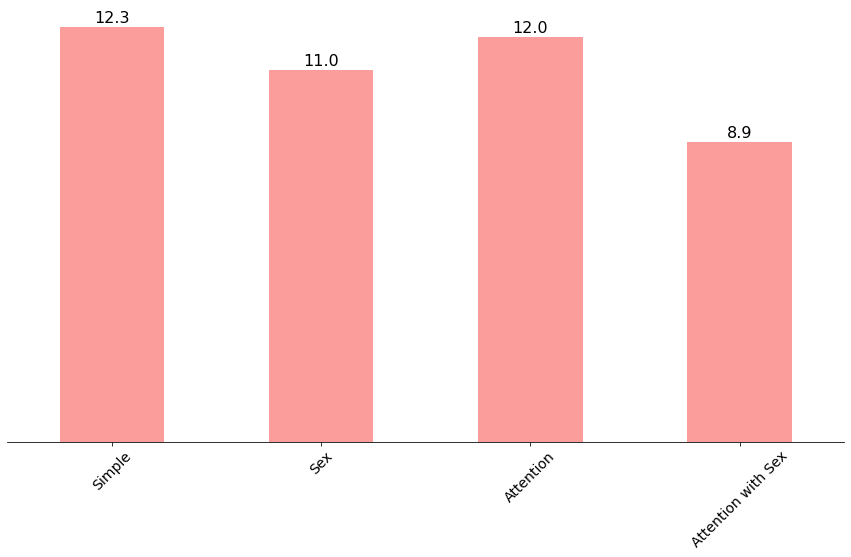

In [ ]:
# Plot MAE for each model
plt.figure(figsize=(15,8))
ax = models_df2['mae'].plot(kind='bar', color='#fb9d9a', width=0.5)

for p in ax.patches:
  ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', 
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.title('Comparison of Models: Mean Absolute Error')
model_names = list(models_df2['models'])

plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.xticks(range(4), labels=model_names, rotation=45, fontsize=14);

### Diagnostic Plots for Models

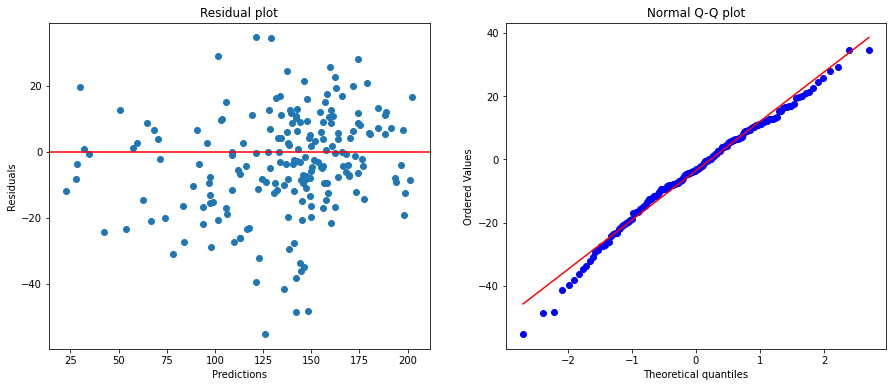

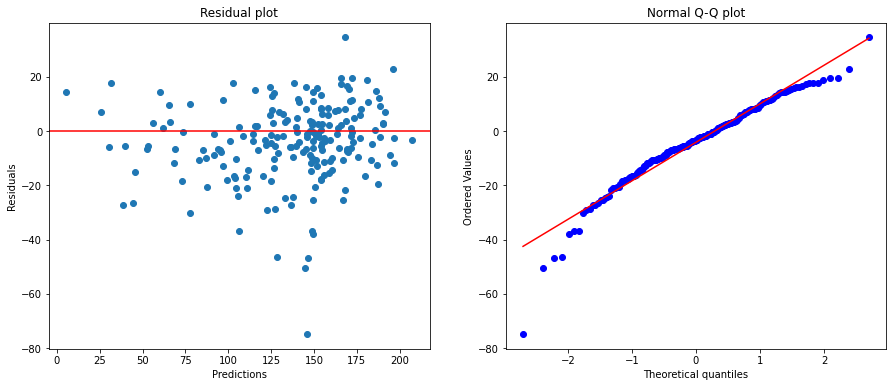

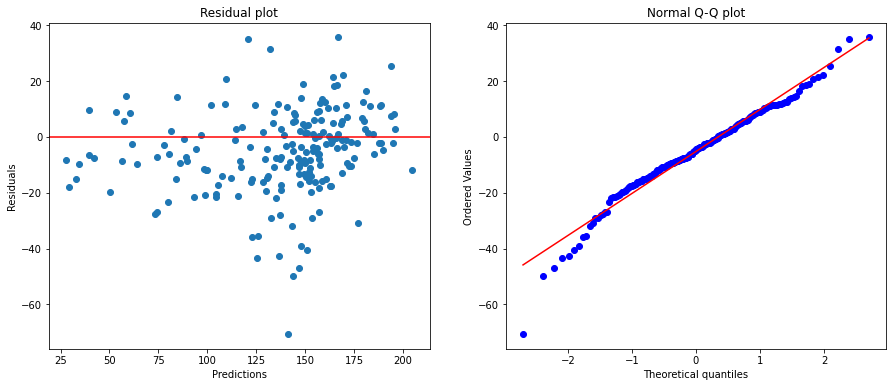

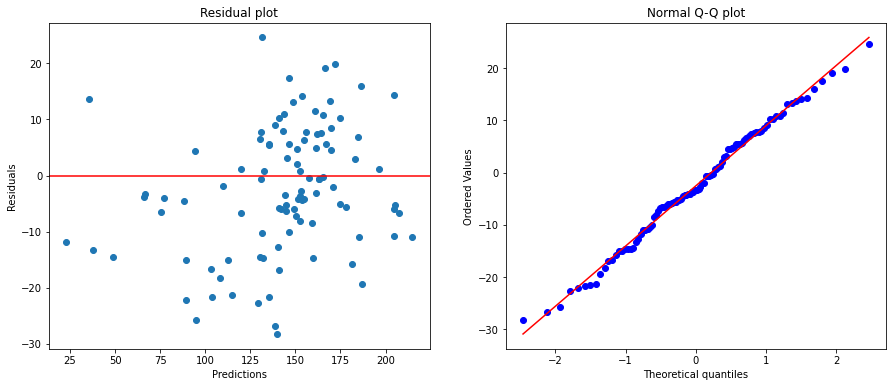

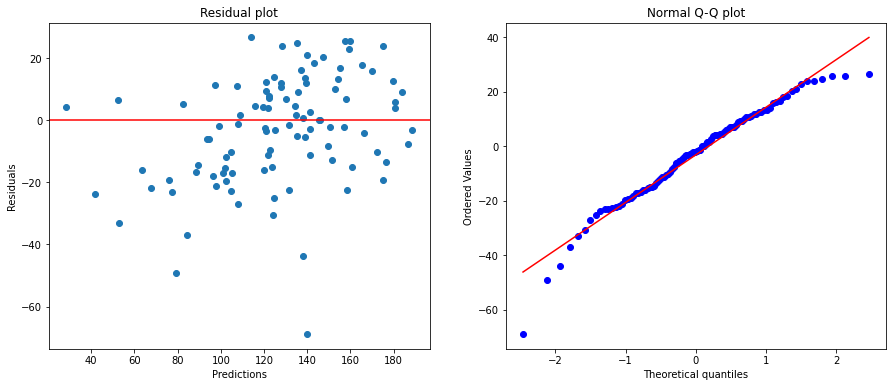

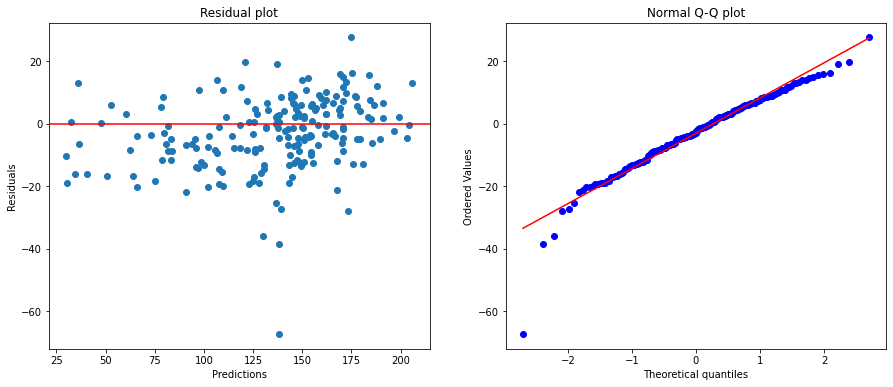

In [ ]:
models_l = ['Simple', 'Gender', 'Attention', 'Attention Male', 'Attention Female', 'Attention with Gender']
preds_df_l = [simple_preds_df, gender_preds_df, attn_preds_df, male_attn_preds_df, female_attn_preds_df, attn_gender_preds_df]

for preds_df in preds_df_l:
  res_plots(preds_df)

There may be a pattern to the residuals across all of the models. The nature of the data may be such that it can be engineered to better suit a regression model.

## Best model: Attention mechanism + sex as feature

Evaluate the best model, which implements the attention mechanism and incorporates sex as a feature

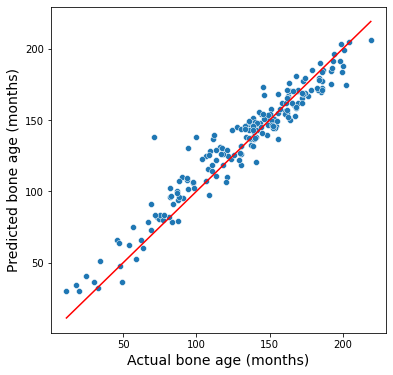

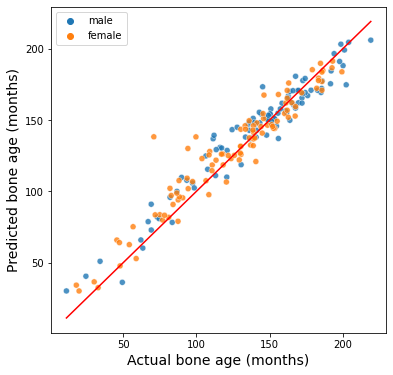

In [ ]:
# Look at predictions
# Plot predictions vs. actual
plot_preds(attn_gender_preds_df, 'Attention w/ Gender Model')
plot_preds_gender(attn_gender_preds_df, 'Attention w/ Gender Model')

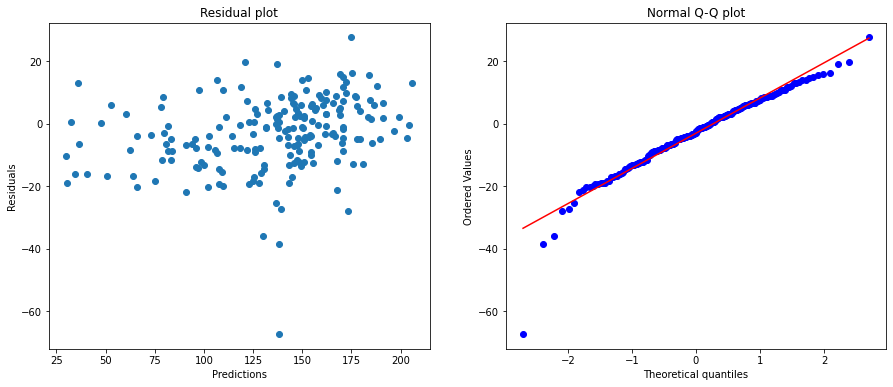

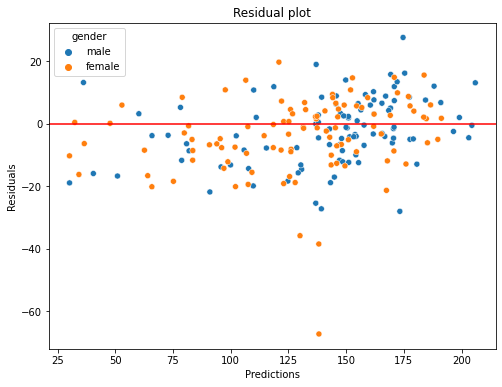

In [ ]:
res_plots(attn_gender_preds_df)
res_plots_gender(attn_gender_preds_df)

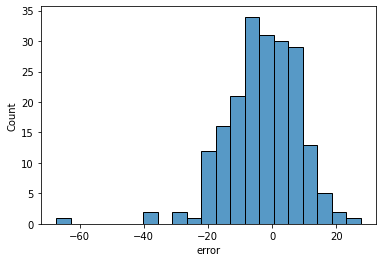

In [ ]:
# Histogram of residuals
sns.histplot(pred_df['error']);

I want to see if there are any differences in the model's performance between males and females.

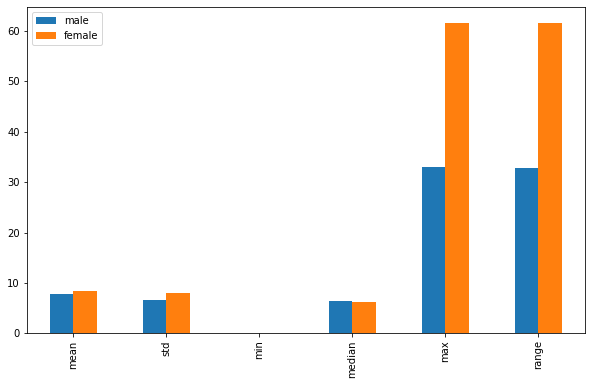

In [ ]:
# Look at descriptive statistics by sex group
gender_stats(attn_gender_preds_df).plot(kind='bar', figsize=(10,6));

It looks like the MAE is higher for females and the maximum error and range are higher for feamles. There also appears to be more variation within the female group.

In [ ]:
# Look at predictions
pred = dict(zip(df_test['filename'], pred_Y))
pred_df = pd.DataFrame.from_dict(pred, orient='index').reset_index()
pred_df.rename(columns={'index': 'filename2', 0: 'pred'}, inplace=True)
pred_df = pd.concat([df_test, pred_df], axis=1)
pred_df.drop(columns={'filename2'}, inplace=True)
pred_df = pred_df[['filename', 'boneage', 'pred', 'gender', 'gender2', 'boneage_zscore']]
pred_df['error'] = pred_df['boneage'] - pred_df['pred']
pred_df.head()

,filename,boneage,pred,gender,gender2,boneage_zscore,error
0,4360.png,168.93,170.504364,male,1,1.005774,-1.574364
1,4361.png,169.65,170.757812,male,1,1.023144,-1.107812
2,4362.png,73.26,81.942200,male,1,-1.302195,-8.682200
3,4363.png,152.86,151.008316,male,1,0.618097,1.851684
4,4364.png,135.46,147.146942,male,1,0.198335,-11.686942


In [ ]:
# Look at top 10 best images
import matplotlib.image as mpimg

for filename, boneage, pred, gender in pred_df_sorted[['filename','boneage','pred', 'gender']].tail(10).values:
    img = mpimg.imread(test_path + filename)
    plt.imshow(img, cmap='bone')
    plt.title('Actual bone age: {} years, Predicted bone age: {} years, Gender: {}'.format(boneage/12, pred/12, gender))
    plt.axis('off')
    plt.show();

In [ ]:
# Look at worst
import matplotlib.image as mpimg

for filename, boneage, pred, gender in pred_df_sorted[['filename','boneage','pred', 'gender']].head(10).values:
    img = mpimg.imread(test_path + filename)
    plt.imshow(img, cmap='bone')
    plt.title('Actual bone age: {} years, Predicted bone age: {} years, Gender: {}'.format(boneage/12, pred/12, gender))
    plt.axis('off')
    plt.show();

In [ ]:
# Best & worst images
pred_df_sorted = attn_gender_preds_df.sort_values(by='abs_error', ascending=True)

pred_df_sorted.head(5)
pred_df_sorted.tail(5)

,filename,boneage,gender,pred,boneage_zscore,error,abs_error,boneage_cat
22,4382.png,136.76,male,136.834213,0.229696,-0.074213,0.074213,"(135.92, 156.705]"
171,4531.png,47.84,female,47.716957,-1.915434,0.123043,0.123043,"(31.995, 52.78]"
199,4559.png,118.23,female,118.485725,-0.217326,-0.255725,0.255725,"(115.135, 135.92]"
145,4505.png,32.86,female,32.434151,-2.276816,0.425849,0.425849,"(31.995, 52.78]"
92,4452.png,157.32,male,157.764343,0.725692,-0.444343,0.444343,"(156.705, 177.49]"


,filename,boneage,gender,pred,boneage_zscore,error,abs_error,boneage_cat
84,4444.png,202.27,male,174.662155,1.810078,27.607845,27.607845,"(198.275, 219.06]"
63,4423.png,145.21,male,173.268936,0.433547,-28.058936,28.058936,"(135.92, 156.705]"
181,4541.png,94.17,female,130.017075,-0.797757,-35.847075,35.847075,"(73.565, 94.35]"
144,4504.png,99.66,female,138.164886,-0.665314,-38.504886,38.504886,"(94.35, 115.135]"
104,4464.png,70.90,female,138.212143,-1.359129,-67.312143,67.312143,"(52.78, 73.565]"


Text(0.5, 1.0, 'Age: 2.7Y\nPredicted Age: 2.7Y')

(-0.5, 298.5, 298.5, -0.5)

Text(0.5, 1.0, 'Age: 13.1Y\nPredicted Age: 13.1Y')

(-0.5, 298.5, 298.5, -0.5)

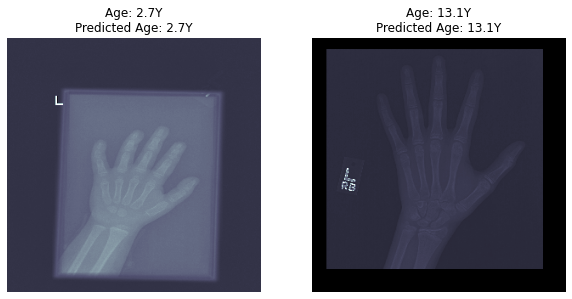

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
# pred_Y = boneage_std*model.predict(test_X, batch_size = 200, verbose = True)+boneage_mean
# test_Y_months = boneage_std*test_Y+boneage_mean

fig, m_axs = plt.subplots(1, 2, figsize = (10, 10))
idx = [145, 92]
for (idx, c_ax) in zip(idx, m_axs.flatten()):
  img = test_X[0][idx:(idx+1)]
  c_ax.imshow(img[0, :,:,0], cmap = 'bone')
  c_ax.set_title('Age: %2.1fY\nPredicted Age: %2.1fY' % (test_Y_months[idx]/12.0, 
                                                           attn_gender_preds[idx]/12.0))
  c_ax.axis('off')

### Simple model

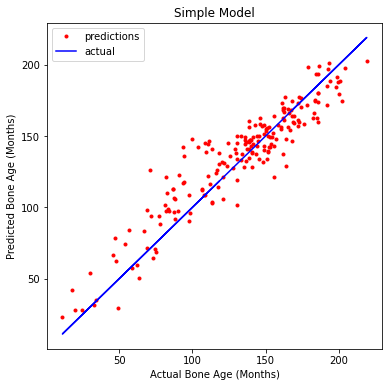

In [ ]:
# Plot predictions
plot_preds('Simple Model', simple_pred_Y, test_Y2_months)

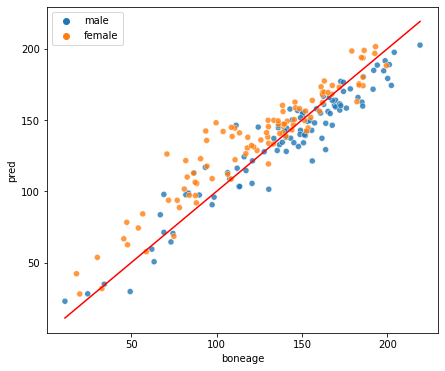

In [ ]:
# Plot predictions by sex
plt.figure(figsize=(7,6))
sns.scatterplot(x='boneage', y='pred', data=simple_pred_df, hue='gender', alpha=0.8)
sns.lineplot(x='boneage', y='boneage', data=simple_pred_df, color='red');

,male,female
mean,10.703803,13.903119
std,8.289998,11.600053
min,0.000424,0.088907
median,8.767947,10.686669
max,34.845026,55.242372
range,34.844602,55.153465


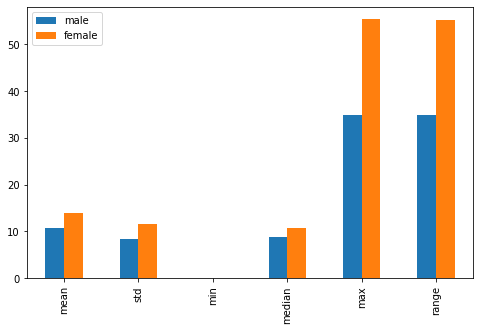

In [ ]:
# Look at error stats by gender
gender_stats(simple_pred_df)
gender_stats(simple_pred_df).plot(kind='bar', figsize=(8,5));

## Gender, No Attention Model

1/1 [==============================] - 0s 2ms/step


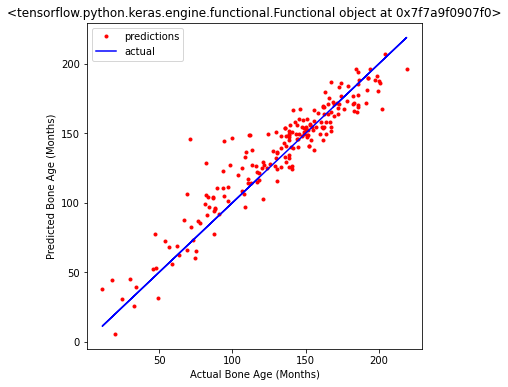

In [ ]:
# Plot predictions
plot_preds(gender_pred_Y, test_Y_months, gender_model)

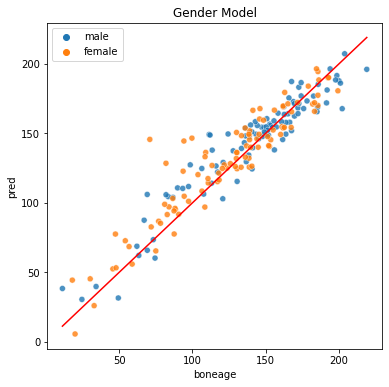

In [ ]:
# Plot predictions by sex
plot_preds_gender(gender_pred_df, 'Sex Model')

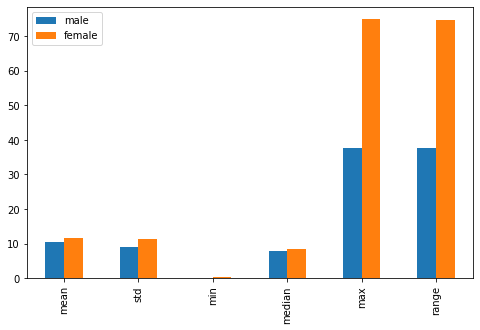

In [ ]:
gender_stats(gender_pred_df).plot(kind='bar', figsize=(8,5));

## Sex

Look at differences in MAE between males & females across all models

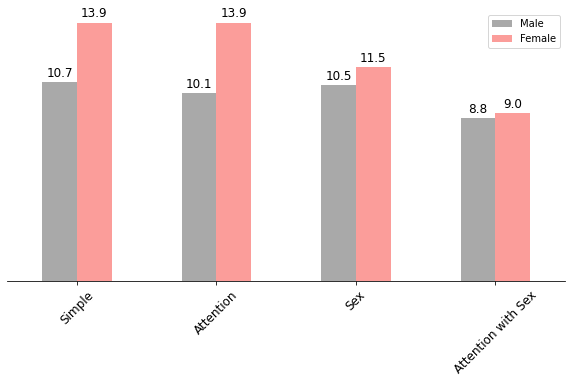

In [ ]:
gender_means_df = pd.concat(
    [simple_gender_mean, attn_gender_mean, gender_gender_mean, attn_gender_gender_mean], axis=1
)
gender_means_df.columns = ['Simple', 'Attention', 'Sex', 'Attention with Sex']
plot = gender_means_df.T.plot(kind='bar', figsize=(10,5),
                              color=['darkgray', '#fb9d9a'])

for p in plot.patches:
  plot.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', 
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=12)

plot.spines['top'].set_visible(False)
plot.spines['right'].set_visible(False)
plot.spines['left'].set_visible(False)

# plt.title('Comparison of Models: Mean Absolute Error')
plt.xlabel('')
plt.ylabel('')
# plt.ylabel('MAE (months)', fontsize=14)
plt.yticks([])
plt.xticks(rotation=45, fontsize=12)
plt.legend(['Male', 'Female']);

We see a higher MAE for females compared to males across all models, and the discrepancy is decreased in those models where sex is incorporated into the model as a feature.

### Age

For the best model (attention mechanism + sex as feature), look at the distribution of MAE by actual bone age to see if age may play a role in the model's performance.

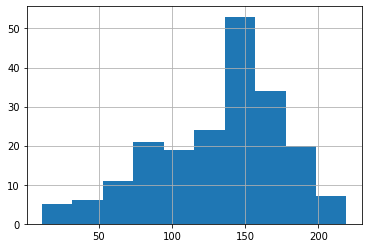

In [ ]:
# Look at distribution of bone aes in test data
df_test['boneage'].hist()

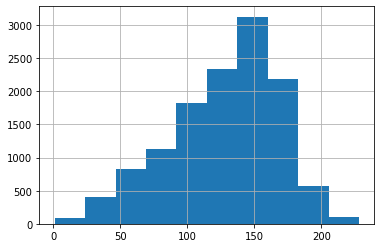

In [ ]:
# Look at distribution of bone ages in training data
df_train['boneage'].hist()

In [ ]:
# Divide bone ages in test set into 2 categories
attn_gender_preds_df['boneage_cat'] = pd.cut(attn_gender_preds_df['boneage'], bins=2)
attn_gender_preds_df['boneage_cat'].value_counts()

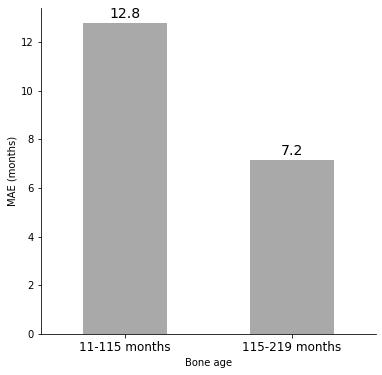

In [ ]:
# Plot MAE for bone age categories
cats = ['11-115 months', '115-219 months']

plt.figure(figsize=(6,6))
ax = attn_gender_preds_df.groupby('boneage_cat').abs_error.mean().plot(kind='bar', color='darkgray')

for p in ax.patches:
  ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', 
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('MAE (months)')
plt.xlabel('Bone age')
plt.xticks(range(len(cats)), labels=cats, rotation=0, fontsize=12);

We see a higher MAE for younger bone ages.

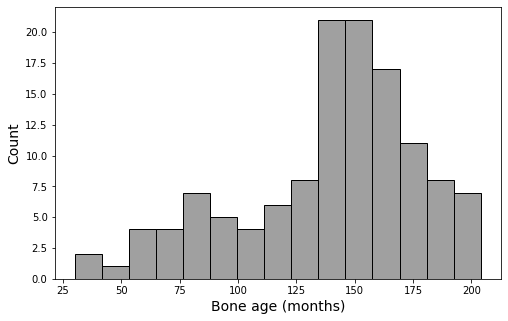

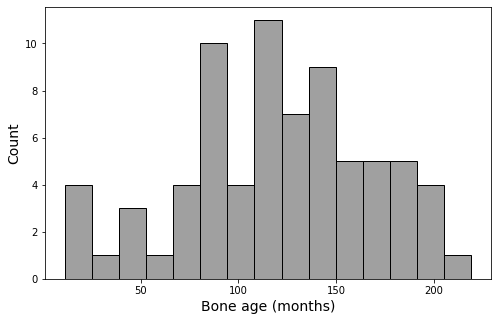

In [ ]:
# Look at distribution of bone ages for subset of data with errors below and above MAE
mae = attn_gender_preds_df['abs_error'].mean()
below_mean = attn_gender_preds_df['abs_error'] <= mae
above_mean = attn_gender_preds_df['abs_error'] > mae

plt.figure(figsize=(8,5))
sns.histplot(attn_gender_preds_df[below_mean]['boneage'], bins=15, color='grey')
plt.xlabel('Bone age (months)', fontsize=14)
plt.ylabel('Count', fontsize=14);

plt.figure(figsize=(8,5))
sns.histplot(attn_gender_preds_df[above_mean]['boneage'], bins=15, color='grey')
plt.xlabel('Bone age (months)', fontsize=14)
plt.ylabel('Count', fontsize=14);

For errors below the MAE for the model, the distribution of bone ages is left-skewed, whereas for errors above the MAE for the model, the distribution of bone ages appears closer to normal.